In [1]:
# SMS Spam Classification - DistilBERT 

from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import os

# Create output directory
os.makedirs("output_model", exist_ok=True)

# Load the SMS Spam dataset
ds_raw = load_dataset("sms_spam")

# Split the dataset into training and test sets
ds_split = ds_raw["train"].train_test_split(test_size=0.2, seed=42)

# Use only 1/5 of the data to speed up training
fraction = 1 / 5
train_num = ds_split["train"].num_rows
test_num = ds_split["test"].num_rows

train_subset = ds_split["train"].shuffle(seed=42).select(range(int(train_num * fraction)))
test_subset = ds_split["test"].shuffle(seed=42).select(range(int(test_num * fraction)))

# Create new dataset dictionary
sms_ds = DatasetDict({
    "train": train_subset,
    "test": test_subset
})

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenization function
def preprocess(example):
    return tokenizer(example["sms"], padding="max_length", truncation=True)

# Apply tokenization
sms_ds = sms_ds.map(preprocess, batched=True)

# Load model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Define evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir="./output_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    eval_steps=50,
    save_steps=50
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=sms_ds["train"],
    eval_dataset=sms_ds["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
result = trainer.evaluate()
print("\nFinal Evaluation Result:", result)

# Save the trained model
trainer.save_model("output_model/final_model")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/1z/6nvfg6sd7lgdqvnb49ny5pfw0000gn/T/ipykernel_44535/2093792182.py:71: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.203100
100,0.039200
150,0.018500



Final Evaluation Result: {'eval_loss': 0.07655474543571472, 'eval_accuracy': 0.9820627802690582, 'eval_precision': 0.9, 'eval_recall': 0.9, 'eval_f1': 0.9, 'eval_runtime': 63.3235, 'eval_samples_per_second': 3.522, 'eval_steps_per_second': 0.221, 'epoch': 3.0}


<Figure size 500x400 with 0 Axes>

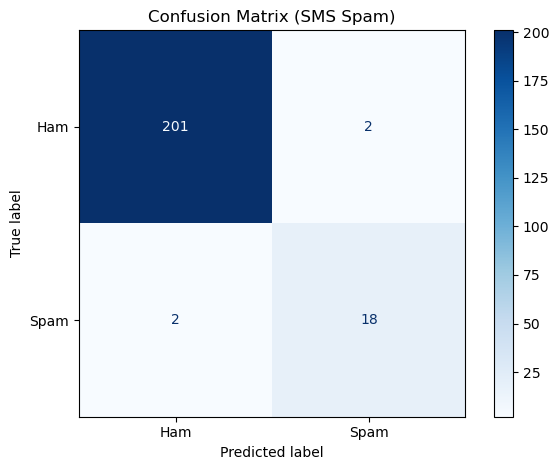

In [3]:
# ==============================
# 💡 Generate Confusion Matrix Image
# ==============================

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions
predictions = trainer.predict(sms_ds["test"])
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Create confusion matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (SMS Spam)")
plt.tight_layout()
plt.savefig("confusion_matrix_real.png")  # Save the image
plt.show()